# Visualize Data Pipeline Effects

This notebook visualizes the effects of the data processing pipeline defined in `oceanwave_forecast/data_pipeline.py`. We will load the raw data, apply the `preprocess_ocean_data` and `get_pipelines` functions, and then plot the data before and after each significant transformation step to visually inspect the changes.

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from datetime import datetime
import importlib

from oceanwave_forecast import data_manager, data_pipeline, config

importlib.reload(data_manager)
importlib.reload(data_pipeline)
importlib.reload(config)

2025-07-20 02:59:51.092 | INFO     | oceanwave_forecast.config:<module>:11 - PROJ_ROOT path is: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast
2025-07-20 02:59:51.095 | INFO     | oceanwave_forecast.config:<module>:11 - PROJ_ROOT path is: D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast


<module 'oceanwave_forecast.config' from 'D:\\CML\\Term 8\\ML projects\\forecasting_workspace\\oceanwave_forecast\\oceanwave_forecast\\config.py'>

## 1. Load and Preprocess Data

In [2]:
folder1_txt = config.RAW_DATA_DIR / 'Standard meteorological data 2024' / '46088h2024.txt'
data_ocean_raw = data_manager.extract_raw_data(folder1_txt)
processed_data = data_pipeline.preprocess_ocean_data(data_ocean_raw)
processed_data = processed_data.loc[config.START_DATE:config.END_DATE]

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_manager.py:43: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


DataFrame shape: (52650, 13)

Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52650 entries, 2024-01-01 00:00:00 to 2024-12-31 23:50:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   WDIR    52650 non-null  float64
 1   WSPD    52650 non-null  float64
 2   GST     52650 non-null  float64
 3   WVHT    52650 non-null  float64
 4   DPD     52650 non-null  float64
 5   APD     52650 non-null  float64
 6   MWD     52650 non-null  float64
 7   PRES    52650 non-null  float64
 8   ATMP    52650 non-null  float64
 9   WTMP    52650 non-null  float64
 10  DEWP    52650 non-null  float64
 11  VIS     52650 non-null  float64
 12  TIDE    52650 non-null  float64
dtypes: float64(13)
memory usage: 5.6 MB

Descriptive statistics:
               WDIR          WSPD           GST          WVHT           DPD  \
count  52650.000000  52650.000000  52650.000000  52650.000000  52650.000000   
mean     194.421026      4.962283      6.

D:\CML\Term 8\ML projects\forecasting_workspace\oceanwave_forecast\oceanwave_forecast\data_pipeline.py:120: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_ocean_hourly = data_ocean_clean.resample('H').mean()


## 2. Get and Apply Pipelines

In [3]:
processed_data_Y = processed_data[config.TARGETS].copy()
processed_data_X = processed_data.drop(columns=config.TARGETS)

pipe_X, pipe_Y = data_pipeline.get_pipelines(list(processed_data_X.columns))

X_transformed = pipe_X.fit_transform(processed_data_X)
Y_transformed = pipe_Y.fit_transform(processed_data_Y)

c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
c:\Users\akashv22\AppData\Local\anaconda3\envs\fc_env\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [4]:
display(pipe_X)

TransformerPipeline(steps=[('imputer',
                            ColumnEnsembleTransformer(remainder='passthrough',
                                                      transformers=[('arima_imp',
                                                                     Imputer(forecaster=AutoARIMA(max_p=3,
                                                                                                  max_q=3,
                                                                                                  n_jobs=-1,
                                                                                                  seasonal=False,
                                                                                                  start_p=1,
                                                                                                  start_q=0,
                                                                                                  suppress_warnings=True),
                                                                             method='forecaster'),
                                                                     ['MWD_sin']),
                                                                    ('ffill_imp',
                                                                     Imputer(method='ffill'),
                                                                     ['WSPD',
                                                                      'GST',
                                                                      'PRES',
                                                                      'ATMP',
                                                                      'WTMP',
                                                                      'DEWP',
                                                                      'WDIR_sin',
                                                                      'WDIR_cos',
                                                                      'MWD_cos'])])),
                           ('scaler',
                            ColumnEnsembleTransformer(remainder='passthrough',
                                                      transformers=[('scaler',
                                                                     TabularToSeriesAdaptor(transformer=StandardScaler()),
                                                                     ['WSPD',
                                                                      'GST',
                                                                      'PRES',
                                                                      'ATMP',
                                                                      'WTMP',
                                                                      'DEWP',
                                                                      'WDIR_sin',
                                                                      'WDIR_cos',
                                                                      'MWD_sin',
                                                                      'MWD_cos'])]))])

In [5]:
display(pipe_Y)

TransformerPipeline(steps=[('imputer', Imputer(method='ffill')),
                           ('scale',
                            TabularToSeriesAdaptor(transformer=StandardScaler()))])

## 3. Visualize Pipeline Effects on Exogenous Variables (X)

### 3.1 Imputation and Scaling

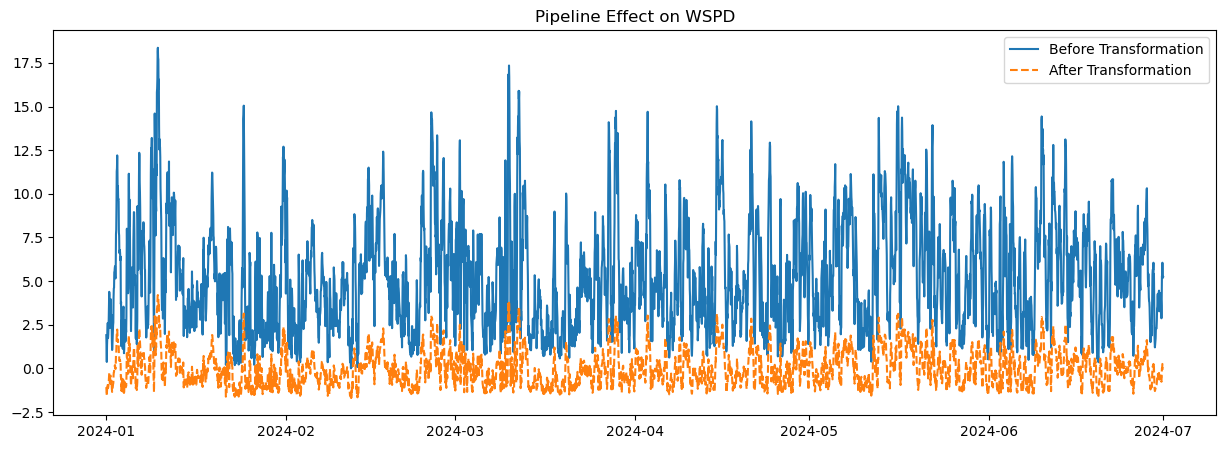

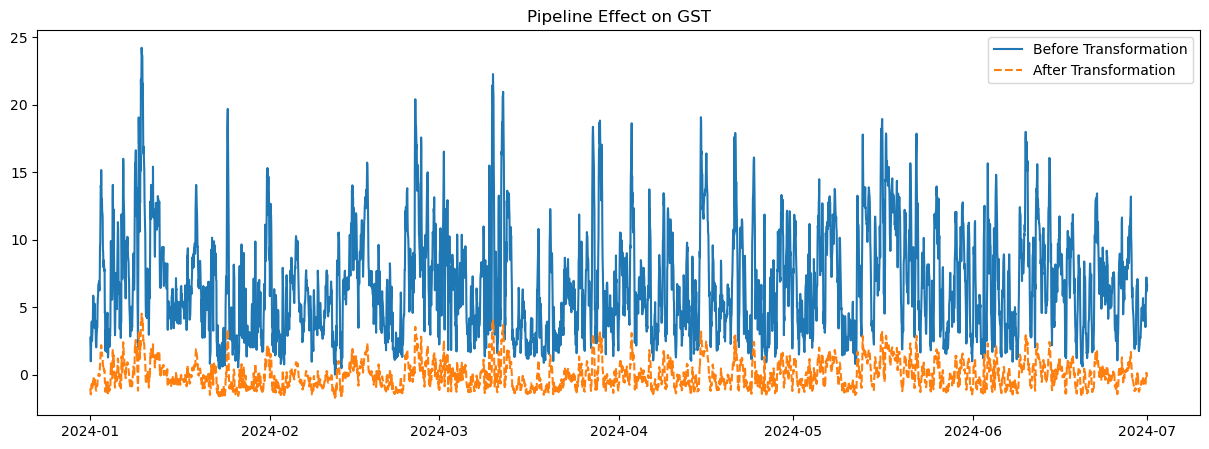

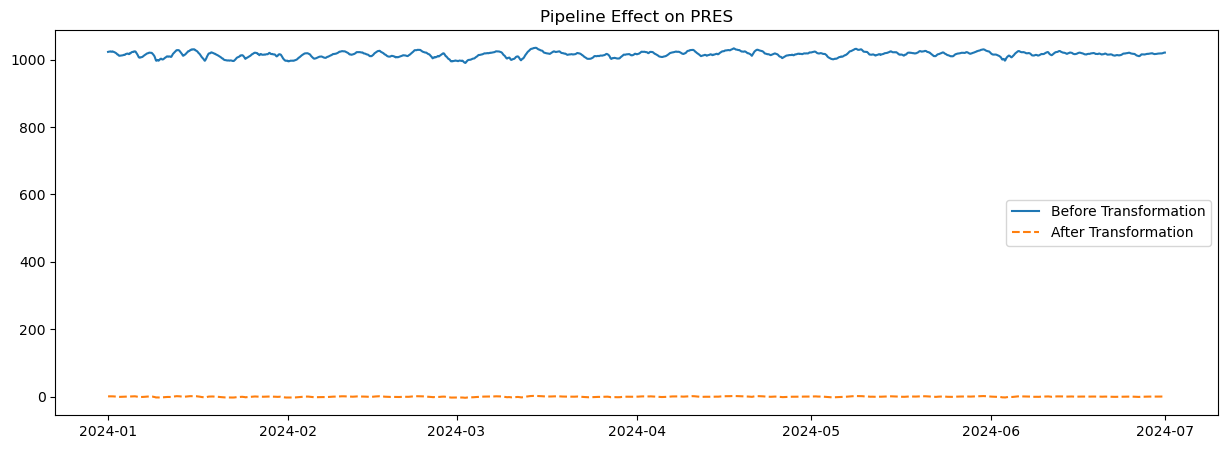

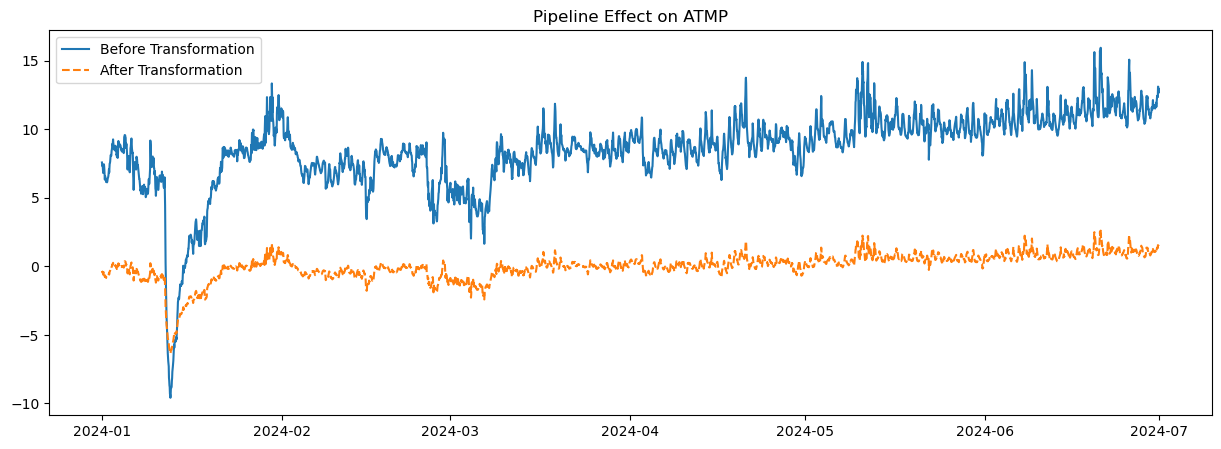

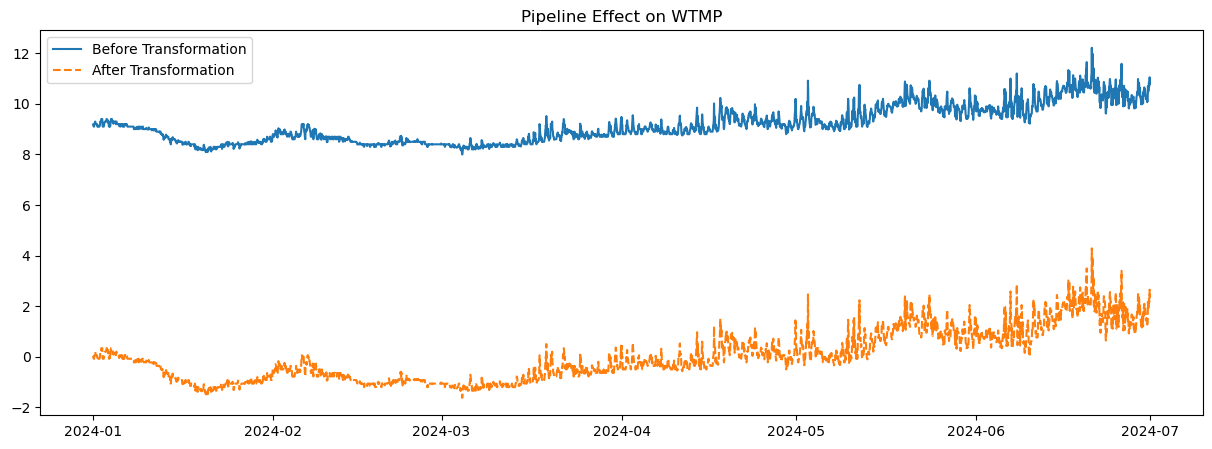

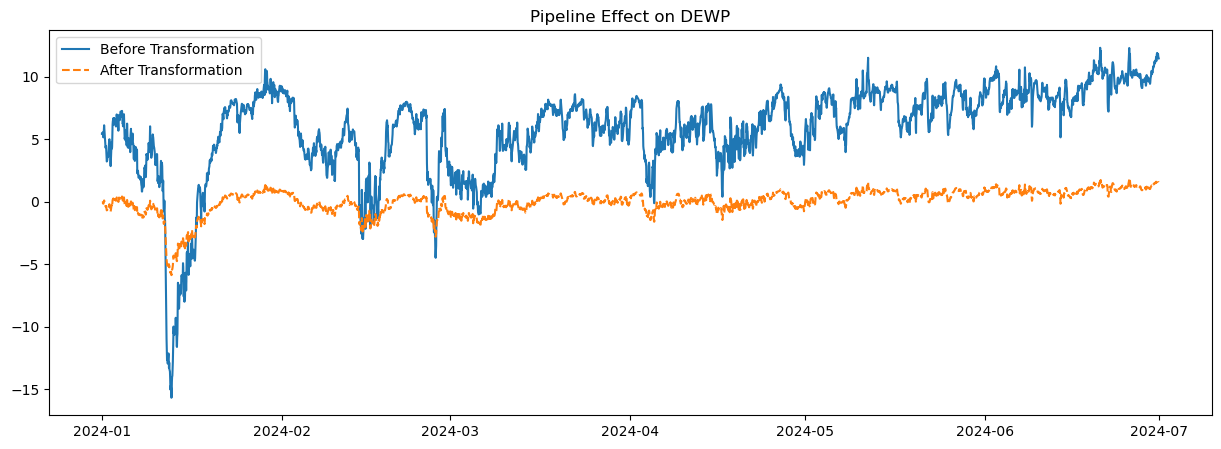

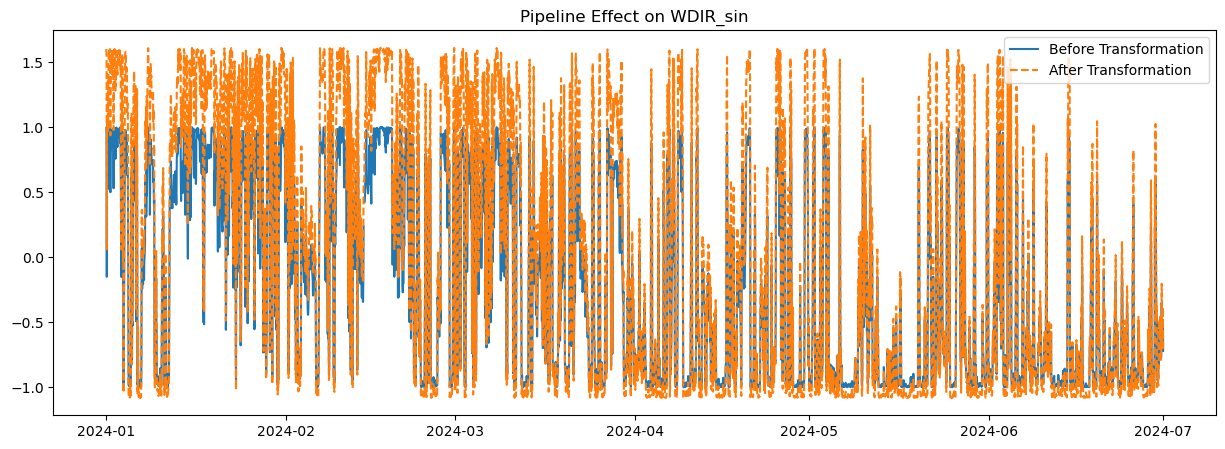

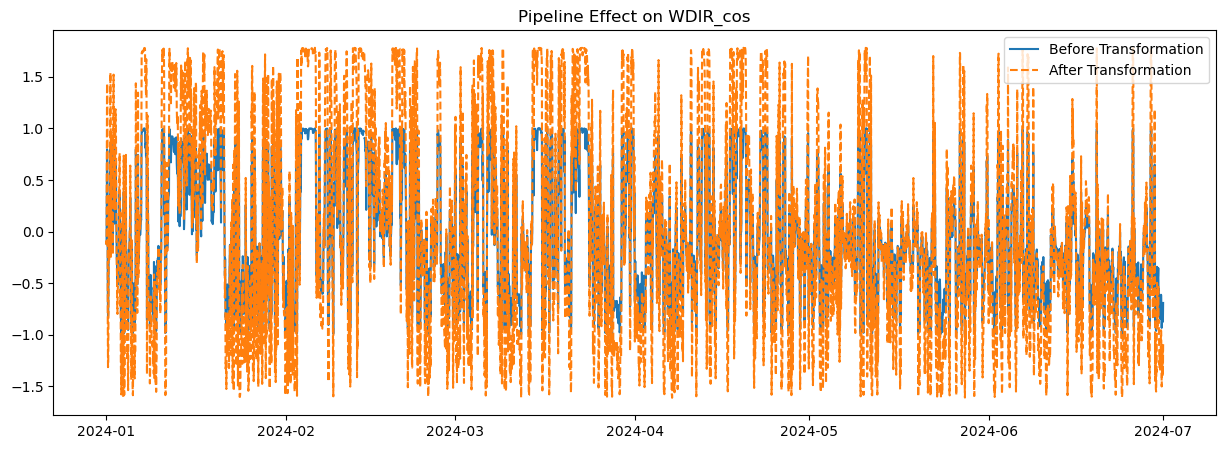

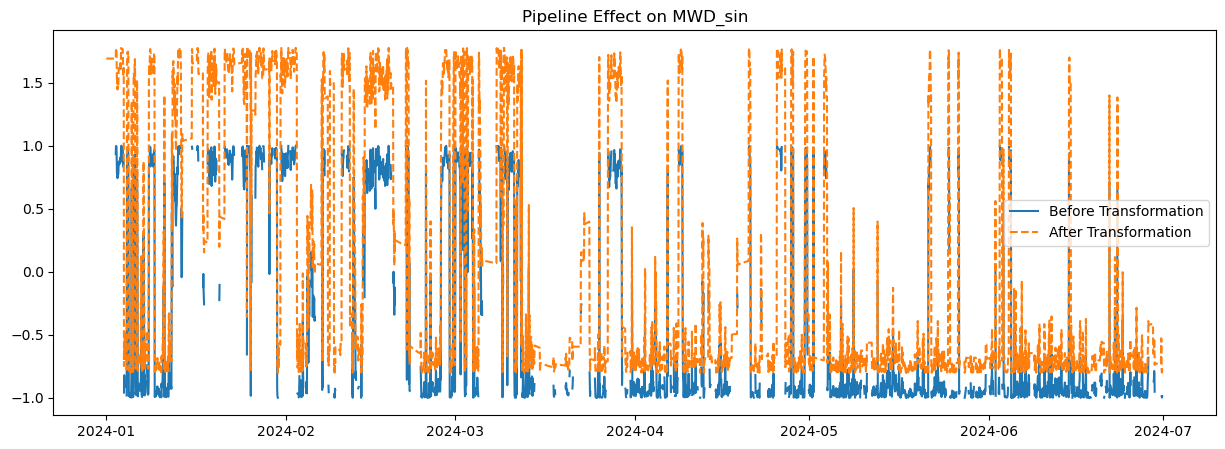

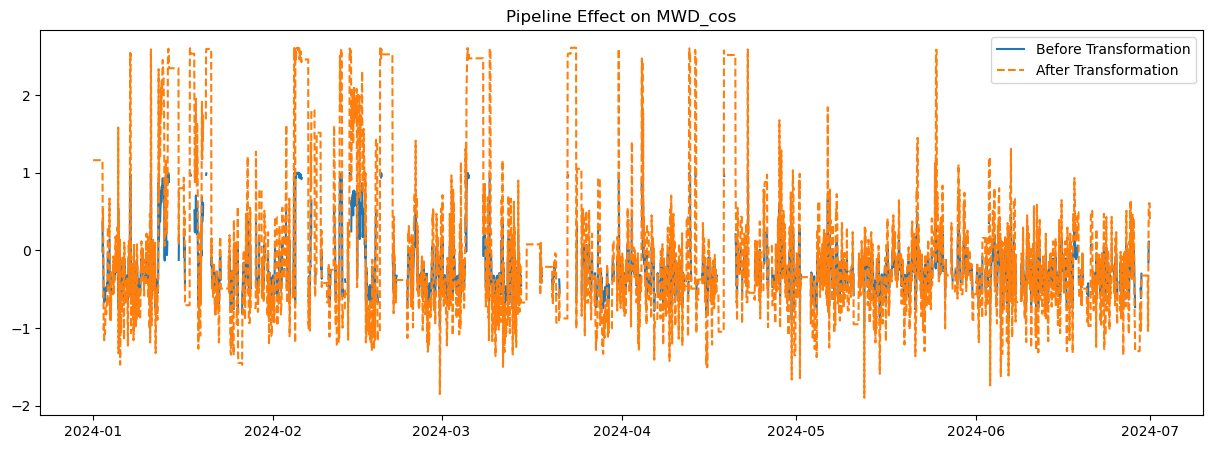

In [6]:
for col in processed_data_X.columns:
    plt.figure(figsize=(15, 5))
    plt.plot(processed_data_X.index, processed_data_X[col], label='Before Transformation')
    plt.plot(X_transformed.index, X_transformed[col], label='After Transformation', linestyle='--')
    plt.title(f'Pipeline Effect on {col}')
    plt.legend()
    plt.show()

## 4. Visualize Pipeline Effects on Target Variables (Y)

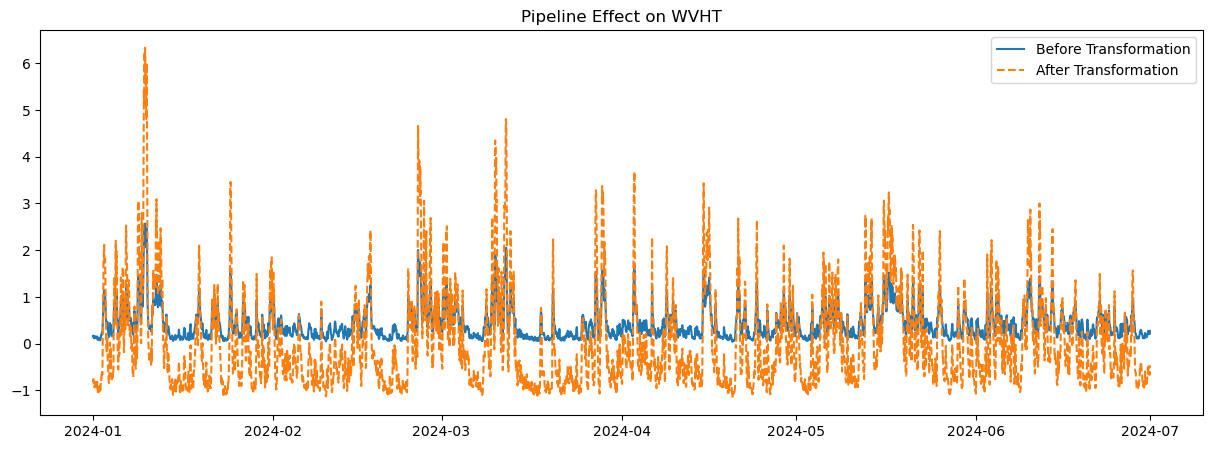

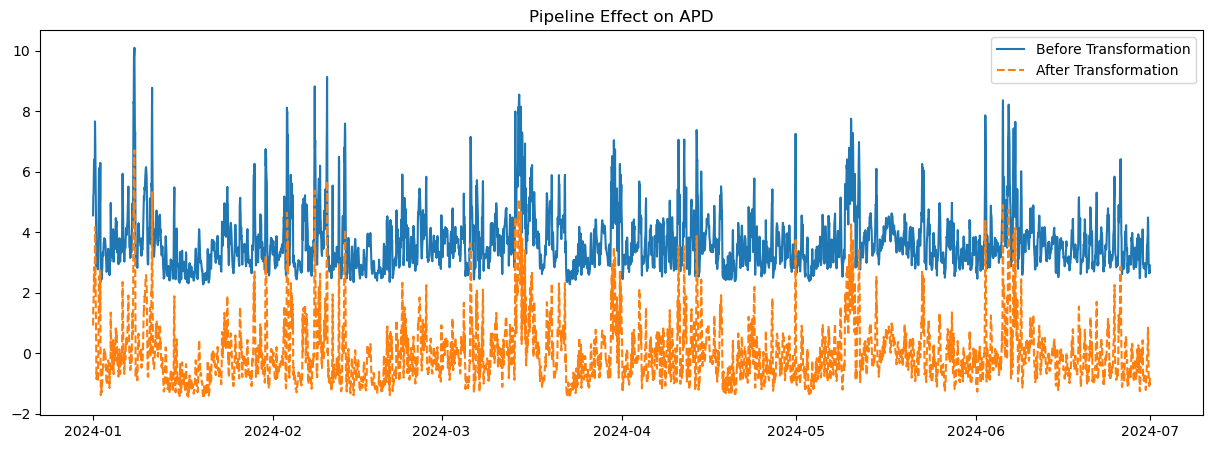

In [7]:
for col in processed_data_Y.columns:
    plt.figure(figsize=(15, 5))
    plt.plot(processed_data_Y.index, processed_data_Y[col], label='Before Transformation')
    plt.plot(Y_transformed.index, Y_transformed[col], label='After Transformation', linestyle='--')
    plt.title(f'Pipeline Effect on {col}')
    plt.legend()
    plt.show()